<IPython.core.display.Javascript object>


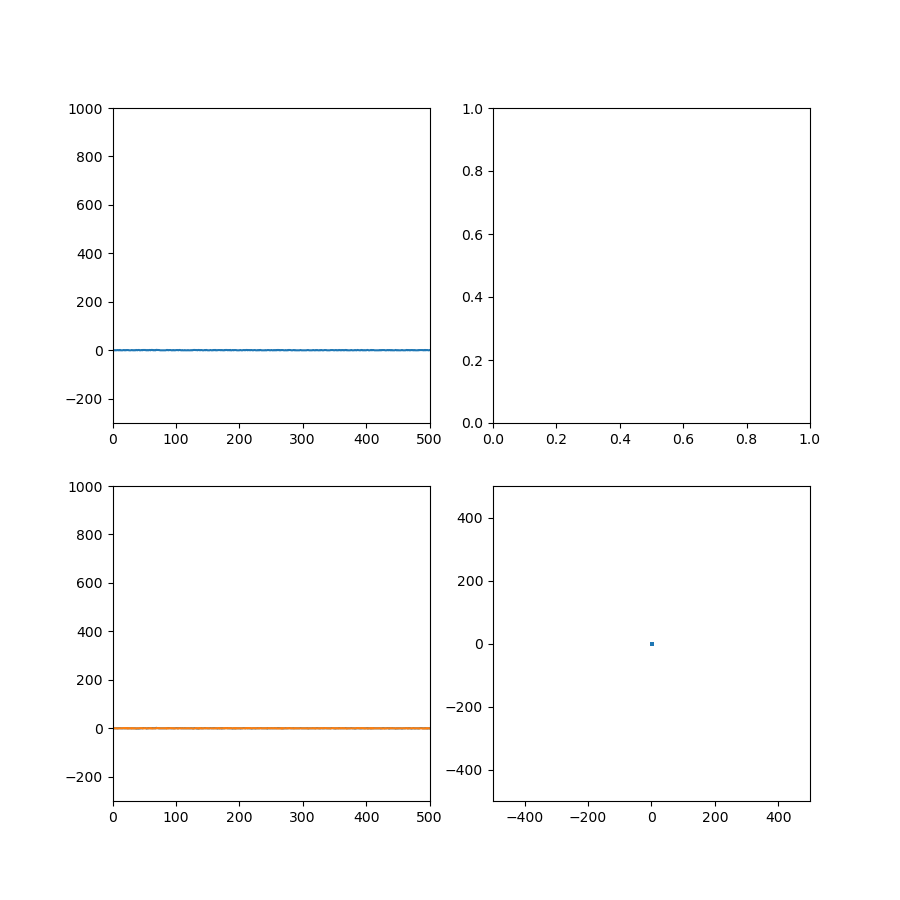

In [5]:
%matplotlib notebook

from random import randint

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import adi
import numpy as np

sdr = adi.Pluto('ip:192.168.2.1') # адрес PlutoSDR
sdr.sample_rate = int(2.5e6)


# create empty lists for the x and y data
x_0 = []
y_0 = []

x_1 = []
y_1 = []

x_2 = []
y_2 = []

x_3 = []
y_3 = []

x_4 = []
y_4 = []

# create the figure and axes objects
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
x_limit = 500
y_limit = 1000
def animate(j):
    rx_data = sdr.rx()
    ifft = np.fft.ifft(rx_data)

    for i in range(len(rx_data)):
        x_0.append(i)
        y_0.append(abs(rx_data[i]))
        
        x_1.append(i)
        y_1.append(rx_data[i].real)
        y_2.append(rx_data[i].imag)
        
        x_3.append(rx_data[i].real)
        y_3.append(rx_data[i].imag)
        
        x_4.append(i)
        y_4.append(abs(ifft[i]))
    

    axs[0, 0].clear()
    axs[0, 0].plot(x_0, y_0)
    axs[0, 0].set_xlim([0,x_limit])
    axs[0, 0].set_ylim([-300,y_limit])
    x_0.clear()
    y_0.clear()
    
    axs[1, 0].clear()
    axs[1, 0].plot(x_1, y_1, x_1, y_2)
    axs[1, 0].set_xlim([0,x_limit])
    axs[1, 0].set_ylim([-300,y_limit])
    x_1.clear()
    y_1.clear()
    y_2.clear()
    
    axs[1, 1].clear()
    axs[1, 1].scatter(x_3, y_3, s=1)
    axs[1, 1].set_xlim([-x_limit,x_limit])
    axs[1, 1].set_ylim([-y_limit/2,y_limit/2])
    x_3.clear()
    y_3.clear()
    
    axs[0, 1].clear()
    axs[0, 1].plot(x_4, y_4, usevlines=True, maxlags=50, normed=True, lw=2)
    axs[0, 1].set_xlim([0,100])
    axs[0, 1].set_ylim([-1,1])
    x_4.clear()
    y_4.clear()
    
# run the animation
ani = FuncAnimation(fig, animate, frames=20, interval=500, repeat=True)

plt.show()

tx samples:  [-11585.23750296+11585.23750296j -11585.23750296+11585.23750296j
 -11585.23750296+11585.23750296j ... -11585.23750296-11585.23750296j
 -11585.23750296-11585.23750296j -11585.23750296-11585.23750296j]
rx_len:  100000
rx_samples:  [-36.-9.j -37.-9.j -35.-8.j ... -36.-9.j -36.-9.j -36.-8.j]


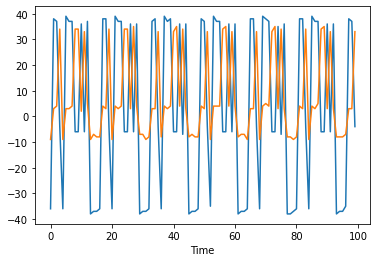

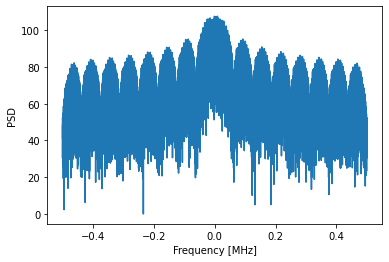

In [4]:
import numpy as np
import adi
import matplotlib.pyplot as plt

sample_rate = 1e6 # Hz
center_freq = 915e6 # Hz
num_samps = 100000 # number of samples per call to rx()

sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = -20 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.rx_lo = int(center_freq)
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.rx_buffer_size = num_samps
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 0.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC

# Create transmit waveform (QPSK, 16 samples per symbol)
num_symbols = 1000
x_int = np.random.randint(0, 4, num_symbols) # 0 to 3
x_degrees = x_int*360/4.0 + 45 # 45, 135, 225, 315 degrees
x_radians = x_degrees*np.pi/180.0 # sin() and cos() takes in radians
x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians) # this produces our QPSK complex symbols
samples = np.repeat(x_symbols, 16) # 16 samples per symbol (rectangular pulses)
samples *= 2**14 # The PlutoSDR expects samples to be between -2^14 and +2^14, not -1 and +1 like some SDRs

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
sdr.tx(samples) # start transmitting
print("tx samples: ", samples)

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()
print("rx_len: ",len(rx_samples))
print("rx_samples: ",rx_samples)

# Stop transmitting
sdr.tx_destroy_buffer()

# Calculate power spectral density (frequency domain version of signal)
psd = np.abs(np.fft.fftshift(np.fft.fft(rx_samples)))**2
psd_dB = 10*np.log10(psd)
f = np.linspace(sample_rate/-2, sample_rate/2, len(psd))

# Plot time domain
plt.figure(0)
plt.plot(np.real(rx_samples[::1000]))
plt.plot(np.imag(rx_samples[::1000]))
plt.xlabel("Time")

# Plot freq domain
plt.figure(1)
plt.plot(f/1e6, psd_dB)
plt.xlabel("Frequency [MHz]")
plt.ylabel("PSD")
plt.show()